Installing necessary libraries

In [1]:
!pip install --upgrade --ignore-installed kaggle

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 153kB 7.4MB/s 
     |████████████████████████████████| 235kB 43.8MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 143kB 51.1MB/s 
     |████████████████████████████████| 184kB 43.2MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=42b99df64fc57fb79f373d88a43dd9d72e63699a09c85407d12b159242062058
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.whl size=6769 sha256=02a782ef4e2eddf1c4d242e493abc78e5ebd0e04bd8658cb5ee2d08c19a490e8
  Stored in directory: /root/.cache/pip/wheels/67/b8/ba/041548f30a6fc058c9b3f79

Uploading data

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ameeraarif","key":"5a2c5d37596e760db6ffa8449f89a47a"}'}

In [3]:
!mkdir ~/.kaggle #created at root folder in colab
#copy
!cp kaggle.json ~/.kaggle

In [4]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d puneet6060/intel-image-classification
#unzip dataset in colab session
!unzip -q intel-image-classification.zip # -q for quiet

 97% 337M/346M [00:01<00:00, 237MB/s]
100% 346M/346M [00:01<00:00, 195MB/s]


In [5]:
#unzip dataset in colab session
# !unzip -q Test_data.zip # -q for quiet

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# copy zipped dataset into your drive
!cp "/content/intel-image-classification.zip" /content/drive/MyDrive/

In [15]:
!unzip Test_datacheck.zip -d new_pred_data

Streaming output truncated to the last 5000 lines.
  inflating: new_pred_data/seg_pred/seg_pred/street/16635.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/15648.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/8704.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/13694.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/2206.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/4649.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/22297.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/9732.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/16177.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/5807.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/17271.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/12443.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/6211.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/2696.jpg  
  inflating: new_pred_data/seg_pred/seg_pred/street/24255.jp

Importing libraries

In [9]:

import sys
import datetime
import glob as glob
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
# from scipy.interpolate import spline
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

Load data

In [11]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (32,32))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels
  

In [12]:
# [Dataset]
# image dimensions for VGG16, VGG19 are 224, 224
# image dimensions for InceptionV3 and Xception are 299, 299
img_width, img_height = 32, 32

train_dir = '/content/seg_train/seg_train'
validate_dir = '/content/seg_test/seg_test'
# test_dir= '/content/new_pred_data/seg_pred/seg_pred'
nb_epochs = 20
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))

In [34]:
print('loading pred images')
X_pred, y_pred = load_data(test_dir)


  9%|▊         | 111/1297 [00:00<00:01, 1106.40it/s]

loading pred images


100%|██████████| 1236/1236 [00:00<00:00, 1618.06it/s]


In [36]:
lb = LabelBinarizer()
y_pred= lb.fit_transform(y_pred)

Image data generator

In [13]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255)

# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255)

# # data pre-processing for testing
# test_datagen =  ImageDataGenerator(
#     rescale = 1./255)



In [14]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

# generate and store testing data
# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size = (img_width, img_height),
#     batch_size = batch_size)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Transfer learning

In [15]:
# set up transfer learning on pre-trained ImageNet VGG19 model - remove fully connected layer and replace
# with softmax for classifying the number of classes in the dataset
vgg16_model = VGG16(weights = 'imagenet', include_top = False)
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
input = vgg16_model.input
output = predictions
model = Model(input, output)

In [16]:
# freeze all layers of the pre-trained InceptionV3 model
for layer in vgg16_model.layers:
    layer.trainable = False

Saving model

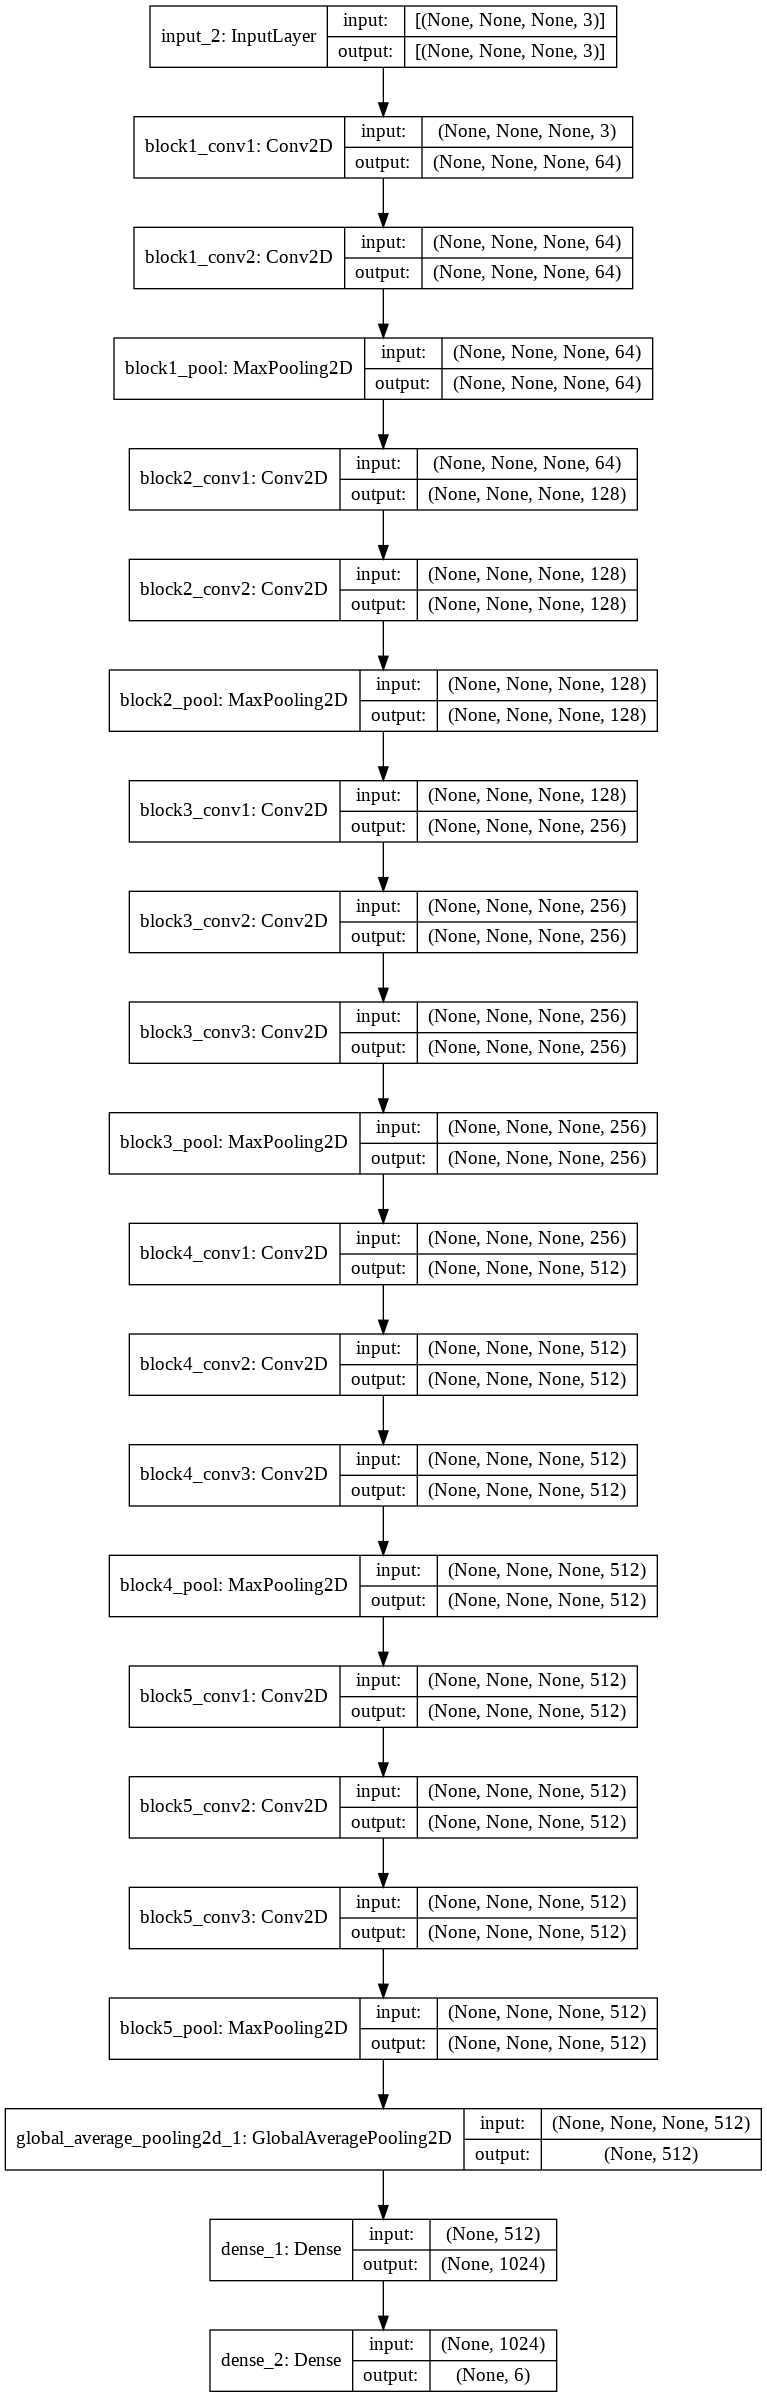

In [18]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="modelTransferL.png", show_shapes=True)

Training on different parameters

In [26]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'RMSprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
H1 = model.fit(
    train_generator,
    batch_size=128,
    epochs=20, 
    validation_data=validate_generator)
print('Training time: %s' % (now() - t))

Epoch 1/20
439/439 [==============================] - 142s 321ms/step - loss: 0.2479 - accuracy: 0.6833 - val_loss: 0.2160 - val_accuracy: 0.7323
Epoch 2/20
439/439 [==============================] - 141s 322ms/step - loss: 0.2015 - accuracy: 0.7399 - val_loss: 0.2228 - val_accuracy: 0.7237
Epoch 3/20
439/439 [==============================] - 141s 321ms/step - loss: 0.1870 - accuracy: 0.7611 - val_loss: 0.1969 - val_accuracy: 0.7517
Epoch 4/20
439/439 [==============================] - 141s 322ms/step - loss: 0.1796 - accuracy: 0.7739 - val_loss: 0.1980 - val_accuracy: 0.7500
Epoch 5/20
439/439 [==============================] - 142s 323ms/step - loss: 0.1684 - accuracy: 0.7925 - val_loss: 0.1970 - val_accuracy: 0.7550
Epoch 6/20
439/439 [==============================] - 142s 324ms/step - loss: 0.1607 - accuracy: 0.8038 - val_loss: 0.2056 - val_accuracy: 0.7480
Epoch 7/20
439/439 [==============================] - 142s 323ms/step - loss: 0.1556 - accuracy: 0.8122 - val_loss: 0.2049 -

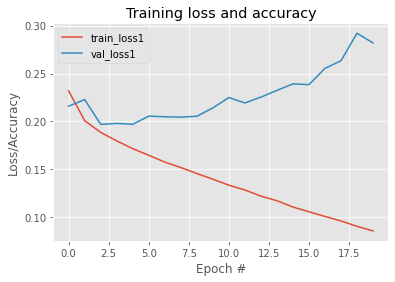

In [27]:

import matplotlib.pyplot as plt
N = np.arange(0, 20)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, H1.history['loss'], label='train_loss1')
plt.plot(N, H1.history['val_loss'], label='val_loss1')
plt.plot(N, H1.history['accuracy'], label='train_accuracy1')
plt.plot(N, H1.history['val_accuracy'], label='val_accuracy1')


plt.title('Training loss and accuracy RMSprop')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [28]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
H2 = model.fit(
    train_generator,
    batch_size=128,
    epochs=20, 
    validation_data=validate_generator)
print('Training time: %s' % (now() - t))

Epoch 1/20
439/439 [==============================] - 141s 320ms/step - loss: 0.0811 - accuracy: 0.9199 - val_loss: 0.2715 - val_accuracy: 0.7563
Epoch 2/20
439/439 [==============================] - 140s 318ms/step - loss: 0.0729 - accuracy: 0.9314 - val_loss: 0.2684 - val_accuracy: 0.7537
Epoch 3/20
439/439 [==============================] - 140s 319ms/step - loss: 0.0655 - accuracy: 0.9400 - val_loss: 0.2761 - val_accuracy: 0.7500
Epoch 4/20
439/439 [==============================] - 140s 320ms/step - loss: 0.0606 - accuracy: 0.9470 - val_loss: 0.2830 - val_accuracy: 0.7447
Epoch 5/20
439/439 [==============================] - 140s 319ms/step - loss: 0.0569 - accuracy: 0.9498 - val_loss: 0.2841 - val_accuracy: 0.7513
Epoch 6/20
439/439 [==============================] - 139s 317ms/step - loss: 0.0504 - accuracy: 0.9556 - val_loss: 0.2942 - val_accuracy: 0.7533
Epoch 7/20
439/439 [==============================] - 138s 315ms/step - loss: 0.0478 - accuracy: 0.9595 - val_loss: 0.3135 -

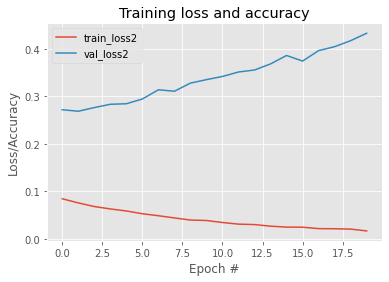

In [29]:

import matplotlib.pyplot as plt
N = np.arange(0, 20)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, H2.history['loss'], label='train_loss2')
plt.plot(N, H2.history['val_loss'], label='val_loss2')
plt.plot(N, H2.history['accuracy'], label='train_accuracy2')
plt.plot(N, H2.history['val_accuracy'], label='val_accuracy2')


plt.title('Training loss and accuracy Adam')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

BEST plots

In [16]:
# compile the new model using a SGD optimizer
model.compile(optimizer = 'sgd',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

In [17]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit(
    train_generator,
    batch_size=128,
    epochs=20, 
    validation_data=validate_generator)
print('Training time: %s' % (now() - t))

Epoch 1/20
439/439 [==============================] - 140s 318ms/step - loss: 0.4427 - accuracy: 0.3589 - val_loss: 0.3705 - val_accuracy: 0.5627
Epoch 2/20
439/439 [==============================] - 139s 317ms/step - loss: 0.3570 - accuracy: 0.5945 - val_loss: 0.3325 - val_accuracy: 0.6050
Epoch 3/20
439/439 [==============================] - 139s 317ms/step - loss: 0.3240 - accuracy: 0.6167 - val_loss: 0.3118 - val_accuracy: 0.6167
Epoch 4/20
439/439 [==============================] - 140s 319ms/step - loss: 0.3052 - accuracy: 0.6307 - val_loss: 0.2987 - val_accuracy: 0.6300
Epoch 5/20
439/439 [==============================] - 140s 319ms/step - loss: 0.2918 - accuracy: 0.6455 - val_loss: 0.2898 - val_accuracy: 0.6413
Epoch 6/20
439/439 [==============================] - 140s 320ms/step - loss: 0.2827 - accuracy: 0.6614 - val_loss: 0.2825 - val_accuracy: 0.6507
Epoch 7/20
439/439 [==============================] - 140s 319ms/step - loss: 0.2758 - accuracy: 0.6624 - val_loss: 0.2767 -

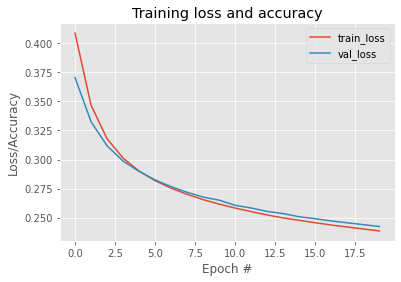

<Figure size 432x288 with 0 Axes>

In [18]:

import matplotlib.pyplot as plt
N = np.arange(0, 20)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, transfer_learning_history.history['loss'], label='train_loss')
plt.plot(N, transfer_learning_history.history['val_loss'], label='val_loss')
plt.plot(N, transfer_learning_history.history['accuracy'], label='train_accuracy')
plt.plot(N, transfer_learning_history.history['val_accuracy'], label='val_accuracy')


plt.title('Training loss and accuracy SGD')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()
plt.savefig('transfer_learning_history.png')

In [24]:
# evaluate the performance the new model and report the results
score = model.evaluate(test_generator 
                      #  nb_validate_samples/batch_size
                      )
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


229/229 [==============================] - 60s 261ms/step - loss: 0.2294 - accuracy: 0.7247
Test Score: 0.22938434779644012
Test Accuracy: 0.7246952652931213


In [25]:
# save transfer learning model for offline prediction purposes
model.save('transferlearning.h5')

In [ ]:
from sklearn.metrics import confusion_matrix

vgg_model.evaluate_generator(test_generator)
y_pred = predY.argmax(1)
confusion_matrix = pd.crosstab(test_generator.classes, y_pred,margins=True)
print("Confusion matrix:\n%s" % confusion_matrix)

In [ ]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = model.predict_classes(X_pred)
y_true = np.argmax(y_pred, axis=-1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

Plot for all hyperparameter settings

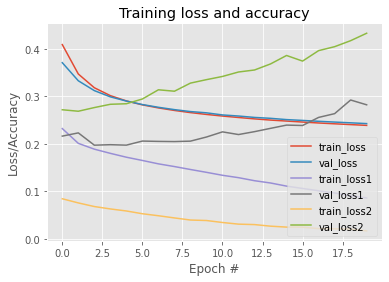

<Figure size 432x288 with 0 Axes>

In [30]:

import matplotlib.pyplot as plt
N = np.arange(0, 20)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, transfer_learning_history.history['loss'], label='train_loss')
plt.plot(N, transfer_learning_history.history['val_loss'], label='val_loss')
# plt.plot(N, transfer_learning_history.history['accuracy'], label='train_accuracy')
# plt.plot(N, transfer_learning_history.history['val_accuracy'], label='val_accuracy')


plt.plot(N, H1.history['loss'], label='train_loss1')
plt.plot(N, H1.history['val_loss'], label='val_loss1')
# plt.plot(N, H1.history['accuracy'], label='train_accuracy1')
# plt.plot(N, H1.history['val_accuracy'], label='val_accuracy1')

plt.plot(N, H2.history['loss'], label='train_loss2')
plt.plot(N, H2.history['val_loss'], label='val_loss2')
# plt.plot(N, H2.history['accuracy'], label='train_accuracy2')
# plt.plot(N, H2.history['val_accuracy'], label='val_accuracy2')


plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()
plt.savefig('transfer_learning_ALL.png')